# 📝 Definição do Problema

## 🎯 Objetivo
O objetivo deste trabalho é desenvolver um **modelo de detecção de phishing** leve, eficiente e capaz de ser integrado em ferramentas de auxílio ao usuário, como **extensões de navegador**. A proposta é criar uma solução **simples, de baixo custo computacional**, mas com desempenho satisfatório para identificar emails phishing de forma confiável.

---

## 🔍 Descrição do Problema
O problema consiste em **classificar emails como phishing ou legítimos** a partir do seu conteúdo textual. Emails phishing geralmente tentam enganar o usuário para obter informações sensíveis ou induzi-lo a executar ações maliciosas. Detectar esses emails de forma automática ajuda a reduzir riscos de segurança.

---

## 💡 Premissas e Hipóteses
- **Premissa:** Emails podem ser diferenciados como phishing ou não a partir de seu texto, sem necessidade de metadados adicionais, embora os metadados também possam ser úteis.
- **Hipótese:** Um modelo baseado em **TF-IDF** para extração de características e um classificador leve (como LGBM) consegue atingir um bom equilíbrio entre **desempenho** e **baixo custo computacional**.
- Embora existam modelos mais robustos baseados em **Transformers**, eles não foram considerados devido ao **alto custo de processamento**, incompatível com o objetivo de um modelo embutido em ferramentas simples.

---

## ⚠️ Restrições e Condições de Seleção dos Dados

- Nesta implementação, foi utilizada **apenas a análise do texto do e-mail** (corpo da mensagem) como entrada do modelo.  
  Essa escolha foi proposital, com o objetivo de manter o foco em **conteúdo textual** e avaliar o desempenho do modelo exclusivamente com base nas palavras utilizadas.  

- No entanto, em um cenário mais amplo, outros **metadados** do e-mail podem contribuir significativamente para a detecção de phishing, como:
  - **Remetente:** endereços suspeitos como `mercadolivre@gmail.com` podem indicar tentativas de se passar por empresas legítimas que normalmente utilizam domínios corporativos.  
  - **Links contidos no corpo do e-mail:** URLs como `mercadolivre.vendasrapidas.com` podem tentar **simular sites oficiais** para enganar o usuário.  
  A análise desses elementos — combinada com o conteúdo textual — tende a **aumentar a robustez do modelo** em aplicações reais.

- A abordagem **TF-IDF** transforma o texto em vetores numéricos baseados na **frequência das palavras** dentro do dataset utilizado para treino.  
  Isso significa que o modelo aprende a importância relativa de cada palavra apenas a partir dos dados disponíveis.  

  ⚠️ **Limitação:** se o dataset tiver um **vocabulário restrito** ou focar em um contexto muito específico, o modelo só conhecerá esse conjunto limitado de palavras.  
  Como resultado, ele pode **não generalizar bem** para e-mails com termos ou expressões diferentes, mesmo que também sejam phishing.  

- Esse é um **trade-off**: ganha-se simplicidade e baixo custo computacional, mas pode-se perder parte da capacidade de generalização.  
  Portanto, é importante utilizar um dataset **abrangente e diversificado**, que represente diferentes contextos de e-mails reais o máximo possível.


---

## 🗂️ Descrição do Dataset
- Url Kaggle: https://www.kaggle.com/datasets/subhajournal/phishingemails
- Url Planilha utilizada pelo notebook: https://docs.google.com/spreadsheets/d/1pQu1m_W_-cyQ6Xu2Ogak31YCuJvHrbZlOSz3PRRXLVE/export?format=csv&sheet=phishing_email
- **Formato:** CSV
- **Colunas:**
  - `Email Text`: corpo do email (string)
  - `Email Type`: classificação (`Safe Email` ou `Phishing Email`)
- **Classe alvo:** `Phishing Email` (1), `Safe Email` (0)
- **Quantidade de registros:** 18.651, com distribuição 60% (safe) / 40% (phishing).




# Instalação de pacotes

In [ ]:
!pip install -q scikit-learn pandas numpy matplotlib seaborn gdown
!pip install lazypredict
!pip install -q transformers sentencepiece langdetect
!pip install deep-translator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, confusion_matrix, recall_score
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import recall_score
import pandas as pd
from sklearn.pipeline import Pipeline
from deep_translator import GoogleTranslator

### 📥 Carregamento e preparação inicial do dataset

Neste trecho, estamos carregando os dados de emails a partir de um arquivo CSV hospedado no **Google Sheets**, o qual foi exportado do Kaggle (https://www.kaggle.com/datasets/subhajournal/phishingemails), e preparando-os para análise e treinamento do modelo.


In [ ]:
url = "https://docs.google.com/spreadsheets/d/1pQu1m_W_-cyQ6Xu2Ogak31YCuJvHrbZlOSz3PRRXLVE/export?format=csv&sheet=phishing_email"

df = pd.read_csv(url)

# Mapear classes para 0/1
df['label'] = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})

df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          18650 non-null  int64 
 1   Email Text  18607 non-null  object
 2   Email Type  18650 non-null  object
 3   label       18650 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 582.9+ KB


(   Id                                         Email Text      Email Type  \
 0   0  re : 6 . 1100 , disc : uniformitarianism , re ...      Safe Email   
 1   1  the other side of * galicismos * * galicismo *...      Safe Email   
 2   2  re : equistar deal tickets are you still avail...      Safe Email   
 3   3  \nHello I am your hot lil horny toy.\n    I am...  Phishing Email   
 4   4  software at incredibly low prices ( 86 % lower...  Phishing Email   
 
    label  
 0      0  
 1      0  
 2      0  
 3      1  
 4      1  ,
 None)

### 📊 Análise exploratória: distribuição de classes e tamanho dos emails

Antes de treinar o modelo, é importante entender **como os dados estão distribuídos**.

1. **Distribuição de classes**  
   - Verificamos o número de emails de cada classe (`Safe Email` e `Phishing Email`) e também a proporção de cada uma em relação ao total.  
   - Isso permite identificar se há **desbalanceamento de classes**, ou seja, se existem muito mais emails legítimos do que phishing.  
   - Entender o balanceamento ajuda a escolher estratégias de treino e métricas apropriadas para avaliação do modelo.

2. **Distribuição do tamanho dos emails**  
   - Calculamos o **número de caracteres de cada email** para entender a variação no tamanho dos textos.  
   - A análise visual mostra se emails de phishing tendem a ser mais curtos ou mais longos que os emails legítimos, permitindo identificar **padrões importantes para o modelo**.  
   - Escalas logarítmicas são úteis quando existem diferenças grandes na quantidade de emails de determinados tamanhos.

✅ **Resumo:**  
Com essa análise inicial, conseguimos insights sobre:
- O **balanceamento das classes**, que impacta diretamente na performance do modelo.  
- O **tamanho típico dos emails**, que pode influenciar a escolha de features de texto, como TF-IDF e n-grams.  

📈 **Resultado observado:**  
A análise mostrou que cerca de **60% dos emails são seguros (Safe Email)** e **40% são phishing**.  
Embora exista um leve **desbalanceamento de classes**, ele é **aceitável** e **reflete bem a realidade**, já que, em contextos reais, a maioria dos emails tende a ser legítima.  
Esse equilíbrio moderado permite que o modelo aprenda bem os dois tipos de mensagens, sem precisar de técnicas complexas de balanceamento.


Distribuição de classes:
label
0    11322
1     7328
Name: count, dtype: int64

Proporção de phishing vs legítimo:
label
0   0.61
1   0.39
Name: proportion, dtype: float64


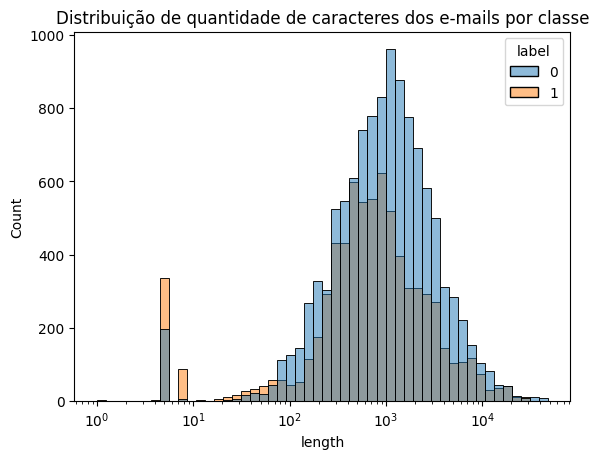

In [ ]:
print("Distribuição de classes:")
print(df['label'].value_counts())
print("\nProporção de phishing vs legítimo:")
print(df['label'].value_counts(normalize=True))

df['length'] = df['Email Text'].fillna('').apply(len)
sns.histplot(data=df, x='length', hue='label', bins=50, log_scale=True)
plt.title("Distribuição de quantidade de caracteres dos e-mails por classe")
plt.show()

### 🧹 Pré-processamento dos textos

Nesta etapa, é realizada a **limpeza e padronização** do conteúdo textual dos e-mails para preparar os dados para o modelo de aprendizado de máquina.  
O processo envolve várias transformações no texto original, com o objetivo de reduzir ruídos e garantir que o algoritmo trabalhe apenas com informações relevantes.

#### ✏️ Etapas do pré-processamento

1. **Conversão para letras minúsculas:**  
   Todos os caracteres são transformados em minúsculos para evitar distinções desnecessárias entre palavras como “Email” e “email”.

2. **Remoção de quebras de linha e espaços extras:**  
   Quebras de linha (`\n`) e múltiplos espaços consecutivos são substituídos por um único espaço, garantindo um texto mais limpo e uniforme.

3. **Remoção de pontuação e símbolos irrelevantes:**  
   São mantidos apenas **letras, números e espaços**. Caracteres especiais (como `@`, `#`, `!`, `?`, etc.) são removidos para eliminar ruídos que não agregam valor ao modelo baseado em palavras.

4. **Tratamento de valores nulos:**  
   Caso algum e-mail esteja vazio, ele é substituído por uma string vazia, evitando erros no processamento.

#### 🎯 Resultado

Após essa etapa, o dataset passa a conter uma nova coluna (`text`) com os e-mails **limpos, padronizados e prontos para serem vetorizados** pelo método **TF-IDF**, usado posteriormente na extração de características textuais.


In [ ]:
def preprocess_text(text):
    text = str(text).lower()
    # Remove quebras de linha e múltiplos espaços
    text = text.replace('\n', ' ')
    text = ' '.join(text.split())
    # Remove pontuação extra, mantendo palavras e números
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# Aplicar ao dataframe
df['text'] = df['Email Text'].fillna('').apply(preprocess_text)

## ⚙️ Vetorização com TF-IDF e Avaliação Automática de Modelos

Após o pré-processamento do texto, é necessário **converter as palavras em números** para que os algoritmos de aprendizado de máquina consigam processar os dados.  
Nesta etapa, é utilizado o **TF-IDF (Term Frequency – Inverse Document Frequency)**, uma técnica clássica e eficiente para representação textual.

---

### 🧠 **1. Separação das variáveis**
- `X` → contém os textos pré-processados.  
- `y` → contém os rótulos numéricos (`0` para *Safe Email* e `1` para *Phishing Email*).  

---

### 🧮 **2. Transformação em vetores numéricos**
É utilizado o `TfidfVectorizer`, que:
- Converte cada e-mail em um vetor de números, refletindo a **importância relativa de cada palavra** no conjunto de dados.  
- Considera **unigramas e bigramas** (`ngram_range=(1,2)`), ou seja, palavras individuais e pares de palavras consecutivas.
- Limita o vocabulário a **500 termos mais relevantes** (`max_features=500`), equilibrando desempenho e consumo de memória.

Essa etapa gera uma **matriz esparsa**, onde cada linha representa um e-mail e cada coluna representa uma palavra ou par de palavras.

---

### 💾 **3. Conversão para matriz densa**
O `LazyClassifier` — biblioteca utilizada para testar rapidamente vários modelos — requer que os dados estejam em formato **denso**.  
Assim, o comando:
```python
X_dense = X_tfidf.toarray()
```

### 🤖 **4. Avaliação automática de modelos**

Nesta etapa, utilizamos o `LazyClassifier` — uma ferramenta que permite **avaliar automaticamente diversos algoritmos de aprendizado de máquina** aplicados ao mesmo conjunto de dados.  
O objetivo é conduzir uma **comparação empírica e científica** entre diferentes modelos, observando métricas como **Acurácia, F1-Score, ROC AUC**, entre outras.

Essa metodologia possibilita identificar **qual algoritmo apresenta melhor desempenho** para o cenário em questão, sem precisar treinar manualmente cada modelo.

Além disso, o `LazyClassifier` oferece um ranking final, ordenando os modelos de acordo com suas métricas de performance.  
Dessa forma, o processo de escolha do modelo mais adequado torna-se **objetivo, reprodutível e fundamentado em resultados quantitativos**.


In [ ]:
X = df['text']
y = df['label']

# TF-IDF (limitar max_features para não estourar memória)
tfidf = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(X)

# Converter para dense array, necessário para LazyClassifier
X_dense = X_tfidf.toarray()

# Separação treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, stratify=y, test_size=0.2, random_state=42
)

# Cria o LazyClassifier
clf = LazyClassifier(predictions=True)

# Treina e avalia vários modelos automaticamente
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Exibe ranking dos modelos (por padrão sorted por Accuracy)
print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 5862, number of negative: 9058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 123426
[LightGBM] [Info] Number of data points in the train set: 14920, number of used features: 500
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.392895 -> initscore=-0.435158
[LightGBM] [Info] Start training from score -0.435158
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.95               0.95     0.95      0.95   
XGBClassifier                      0.95               0.95     0.95      0.95   
SVC                                0.95               0.95     0.95      0.95   
RandomForestClassifier             0.95               0.94     0.94      0.95   
ExtraTreesClassifie

## 📊 Avaliação Focada na Classe Positiva (Phishing)

Após a execução do `LazyClassifier`, obtém-se uma tabela com métricas gerais de desempenho de vários algoritmos.  
No entanto, em problemas de **detecção de phishing**, é importante dar **ênfase à classe positiva (1 = Phishing Email)** — já que falsos negativos (phishings não detectados) são muito mais críticos do que falsos positivos.

---

### 🎯 **1. Cálculo do Recall da classe positiva**
O **Recall**, neste caso, mede a capacidade do modelo de **identificar corretamente os e-mails de phishing**.  

Ou seja, quanto maior o *Recall*, menor a chance de o modelo deixar passar um e-mail malicioso.

No código, é criado um dicionário (`recalls`) que armazena o *Recall* da classe positiva (`pos_label=1`) para cada modelo avaliado.

---

### 📈 **2. Inclusão do Recall na tabela de resultados**
O valor do *Recall* é adicionado à tabela original de modelos (`models`), gerando um novo *DataFrame* (`models_with_recall`) com uma coluna adicional chamada **“Recall”**.

---

### 🔽 **3. Ordenação por desempenho em Recall**
Por fim, a tabela é reordenada de forma decrescente pelo *Recall*, com:
```python
sort_values(by='Recall', ascending=False)
```

---

### 🧠 **4. Escolha do modelo ideal**
Com base na tabela ordenada, o modelo selecionado foi aquele que **apresentou o maior valor de *Recall*** (ou seja, melhor capacidade de detectar e-mails de phishing) **e o menor tempo de execução**.  

Neste caso, específico, foi o modelo `LGBMClassifier`.

Essa escolha prioriza a **eficiência na detecção de ameaças** sem comprometer o **desempenho computacional** — garantindo que o sistema seja tanto **preciso** quanto **ágil** na identificação de e-mails maliciosos.



In [ ]:
# Calcula Recall da classe positiva (1 = Phishing Email)
recalls = {model: recall_score(y_test, predictions[model], pos_label=1)
           for model in predictions.columns}

# Adiciona Recall à tabela original
models_with_recall = models.join(pd.DataFrame.from_dict(recalls, orient='index', columns=['Recall']))

# Ordena pelo Recall
models_with_recall_sorted = models_with_recall.sort_values(by='Recall', ascending=False)

print(models_with_recall_sorted)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
LGBMClassifier                     0.95               0.95     0.95      0.95   
XGBClassifier                      0.95               0.95     0.95      0.95   
GaussianNB                         0.87               0.88     0.88      0.87   
SVC                                0.95               0.95     0.95      0.95   
LinearSVC                          0.94               0.94     0.94      0.94   
KNeighborsClassifier               0.76               0.80     0.80      0.77   
CalibratedClassifierCV             0.94               0.94     0.94      0.94   
LogisticRegression                 0.94               0.94     0.94      0.94   
RidgeClassifierCV                  0.93               0.93     0.93      0.93   
RidgeClassifier                    0.93               0.93     0.93      0.93   
LinearDiscriminantAnalysis  

## 🧠 Preparação dos Dados e Extração de Características com TF-IDF

Esta etapa é responsável por preparar os dados para o treinamento do modelo de aprendizado de máquina.  
Ela envolve duas fases principais: **divisão dos dados** e **transformação textual com TF-IDF**.

---

### ✂️ **1. Separação entre features e rótulos**
Primeiro, as colunas são separadas:
- `X` contém o **texto dos e-mails** (`Email Text`);
- `y` contém a **classificação alvo**, mapeada para valores numéricos:
  - `0` → *Safe Email* (e-mail legítimo)  
  - `1` → *Phishing Email* (e-mail malicioso)

Essa codificação binária é essencial para que o modelo possa interpretar corretamente as classes durante o treinamento.

---

### 🔀 **2. Divisão em conjuntos de treino e teste**
Os dados são divididos em:
- **Treino (80%)** → usado para o modelo “aprender” padrões linguísticos;
- **Teste (20%)** → usado para avaliar a capacidade do modelo de generalizar para novos dados.

O parâmetro `stratify=y` garante que a proporção entre e-mails legítimos e de phishing seja **mantida em ambos os conjuntos**, evitando viés de amostragem.

---

### 🧩 **3. Extração de características com TF-IDF**
O texto cru dos e-mails não pode ser usado diretamente pelos algoritmos de machine learning.  
Por isso, é convertido em **vetores numéricos** por meio da técnica **TF-IDF (Term Frequency – Inverse Document Frequency)**.

- `max_features=2000` → limita o vocabulário a **2.000 termos mais relevantes**, equilibrando desempenho e memória.  
- `ngram_range=(1,2)` → considera **unigramas** (palavras isoladas) e **bigramas** (pares de palavras consecutivas), permitindo capturar expressões comuns como *"click here"* ou *"account suspended"*.

Após o ajuste (`fit_transform`) no conjunto de treino, o mesmo vocabulário é usado para transformar o conjunto de teste (`transform`), garantindo consistência.

---

💡 **Em resumo:**  
Esta etapa converte o conteúdo textual dos e-mails em representações numéricas otimizadas para aprendizado, preparando o terreno para o treinamento e a avaliação de modelos de detecção de phishing.


In [ ]:
# -------------------------
# Separar X e y
X = df['Email Text'].fillna('')
y = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})  # codifica 0/1

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# -------------------------
# TF-IDF
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### 🔄 Validação Cruzada com LGBM

Para avaliar a robustez do modelo antes de testá-lo em dados externos, realizamos **Validação Cruzada Estratificada (Stratified K-Folds)** com 5 folds.  

---

#### 🛠 Passos:

1. **Definição do modelo LGBM**  
   Configuramos um **LightGBM Classifier** com:
   - `n_estimators=500`: número de árvores no ensemble.
   - `learning_rate=0.05`: taxa de aprendizado.
   - `random_state=42`: para reprodutibilidade.

2. **Criação dos folds estratificados**  
   Usando `StratifiedKFold`, garantimos que cada fold mantém a **mesma proporção de classes** (Safe vs Phishing) do conjunto de treino.

3. **Execução da Validação Cruzada**  
   O `cross_val_score` calcula o **ROC AUC** em cada fold, fornecendo uma medida de **desempenho médio do modelo** em diferentes subconjuntos dos dados.

4. **Resultados**  
   - `ROC AUC médio`: indica a **capacidade geral do modelo de discriminar entre e-mails legítimos e de phishing**.
   - `Desvio padrão entre folds`: mostra a **consistência do modelo**; valores baixos indicam que o desempenho não varia muito entre diferentes divisões dos dados.

In [ ]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

# Cria folds estratificados (mantém proporção entre classes)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Executa cross-validation
scores = cross_val_score(lgbm, X_train_tfidf, y_train, cv=cv, scoring='roc_auc')

print(f"ROC AUC médio na validação cruzada: {np.mean(scores):.4f}")
print(f"Desvio padrão entre folds: {np.std(scores):.4f}")

[LightGBM] [Info] Number of positive: 4689, number of negative: 7247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.403742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275588
[LightGBM] [Info] Number of data points in the train set: 11936, number of used features: 1993
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.392845 -> initscore=-0.435368
[LightGBM] [Info] Start training from score -0.435368
[LightGBM] [Info] Number of positive: 4689, number of negative: 7247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.409655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 275756
[LightGBM] [Info] Number of data points in the train set: 11936, number of used features: 1993
[LightGBM] [In

### 🏋️ Treinamento do LGBMClassifier

Após a avaliação inicial com Validação Cruzada, o **LightGBM Classifier** é treinado no **conjunto de treino completo**.

---

#### 🛠 Configuração do modelo:

- `n_estimators=500`: número de árvores na floresta, controlando a complexidade do ensemble.
- `learning_rate=0.05`: taxa de aprendizado, determinando o quanto cada árvore contribui para o modelo final.
- `random_state=42`: garante que o treinamento seja reprodutível.

---

In [ ]:
# -------------------------
# Treinar LGBMClassifier
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)
lgbm.fit(X_train_tfidf, y_train)

[LightGBM] [Info] Number of positive: 5862, number of negative: 9058
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.550234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319904
[LightGBM] [Info] Number of data points in the train set: 14920, number of used features: 1997
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.392895 -> initscore=-0.435158
[LightGBM] [Info] Start training from score -0.435158


LGBMClassifier(learning_rate=0.05, n_estimators=500, random_state=42)

### 🧪 Função `avaliar_modelo`

A função `avaliar_modelo` permite **avaliar um modelo de classificação** em um conjunto de teste, gerando métricas clássicas e exibindo exemplos de predições incorretas.

---

#### 🔹 Parâmetros:

- `modelo`: modelo treinado (pode ser pipeline ou classificador com métodos `predict` e `predict_proba`).
- `X_test`: dados de teste (TF-IDF, pipeline, etc.).
- `y_test`: labels correspondentes.
- `X_textos` textos originais correspondentes a `X_test`. Útil para inspecionar erros.
- `target_names`: nomes das classes para exibição (`['Safe Email', 'Phishing Email']` por padrão).
- `titulo_matriz`: título para a matriz de confusão.
- `n_erros`: número de exemplos de predições incorretas a exibir.

---

#### ⚡ Funcionalidades:

1. **Predição**  
   O modelo faz predições sobre `X_test` com `predict` e calcula probabilidades com `predict_proba`.

2. **Relatório de classificação**  
   Exibe `precision`, `recall`, `f1-score` e `support` para cada classe.

3. **Métricas adicionais**  
   Calcula e exibe:
   - **ROC AUC**: mede a capacidade do modelo de separar classes.
   - **PR AUC**: área sob a curva Precision-Recall.

4. **Matriz de Confusão**  
   Gera visualização da matriz de confusão para análise de acertos e erros por classe.

5. **Exemplos de predições incorretas** *(se `X_textos` for fornecido)*  
   Exibe os primeiros `n_erros` textos onde o modelo errou, mostrando:
   - Valor verdadeiro
   - Predição do modelo
   - Texto do e-mail

---

Essa função é útil para **análise qualitativa e quantitativa do modelo**, permitindo identificar padrões de erro e avaliar seu desempenho em dados reais.


In [ ]:
def avaliar_modelo(modelo, X_test, y_test, X_textos=None, target_names=['Safe Email', 'Phishing Email'],
                    titulo_matriz="Matriz de Confusão", n_erros=5):
    """
    Avalia um modelo em um conjunto de teste.

    Parâmetros:
    - modelo: pipeline ou modelo treinado com métodos predict e predict_proba
    - X_test: dados de teste (TF-IDF, pipeline, etc.)
    - y_test: labels correspondentes
    - X_textos: lista/Series com os textos originais correspondentes a X_test (opcional)
    - target_names: nomes das classes
    - titulo_matriz: título da matriz de confusão
    - n_erros: número de exemplos de predições incorretas a exibir
    """

    # Predição
    y_pred = modelo.predict(X_test)

    # Probabilidade da classe positiva
    y_proba = modelo.predict_proba(X_test)[:, 1]

    # Relatório de classificação
    print("===== RELATÓRIO DE CLASSIFICAÇÃO =====\n")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Métricas de ROC AUC e PR AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")

    # Matriz de confusão
    cm = ConfusionMatrixDisplay.from_estimator(
        modelo,
        X_test,
        y_test,
        display_labels=target_names,
        cmap=plt.cm.Blues,
        normalize=None
    )
    plt.title(titulo_matriz)
    plt.show()

    # Exibir exemplos de predições incorretas
    if X_textos is not None:
        print(f"\n===== {n_erros} EXEMPLOS DE PREDIÇÕES INCORRETAS =====\n")
        erros_idx = [i for i in range(len(y_test)) if y_test.iloc[i] != y_pred[i]] if hasattr(y_test, "iloc") else [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
        for i in erros_idx[:n_erros]:
            true_label = target_names[y_test.iloc[i]] if hasattr(y_test, "iloc") else target_names[y_test[i]]
            pred_label = target_names[y_pred[i]]
            texto = X_textos.iloc[i] if hasattr(X_textos, "iloc") else X_textos[i]
            print(f"Verdadeiro: {true_label} | Predição: {pred_label}\nTexto: {texto}\n{'-'*60}\n")


## 🧪 Avaliação do Modelo nos Dados de Teste

Para avaliar o desempenho do modelo treinado (`LGBMClassifier`) nos dados de teste, foi utilizada a função `avaliar_modelo` criada acima.

Essa função realiza as seguintes etapas:

1. **Predição e probabilidades**  
   O modelo é utilizado para prever as classes dos e-mails de teste (`X_test_tfidf`).  
   Também são calculadas as probabilidades associadas à classe positiva (1 = Phishing Email), que são usadas para métricas como ROC AUC e PR AUC.

2. **Relatório de classificação**  
   É exibido um resumo com métricas padrão (`precision`, `recall`, `f1-score`) para cada classe, permitindo analisar a performance geral do modelo.

3. **Matriz de confusão**  
   A matriz de confusão mostra visualmente a distribuição de predições corretas e incorretas, destacando falsos positivos e falsos negativos.

4. **Exemplos de predições incorretas**  
   Passando os textos originais (`X_test`) para o parâmetro `X_textos`, a função exibe alguns casos de e-mails classificados incorretamente, mostrando:
   - O valor verdadeiro (`Safe Email` ou `Phishing Email`)  
   - A predição do modelo  
   - O conteúdo do e-mail

===== RELATÓRIO DE CLASSIFICAÇÃO =====

                precision    recall  f1-score   support

    Safe Email       0.98      0.96      0.97      2264
Phishing Email       0.94      0.97      0.95      1466

      accuracy                           0.96      3730
     macro avg       0.96      0.96      0.96      3730
  weighted avg       0.96      0.96      0.96      3730

ROC AUC: 0.9945
PR AUC: 0.9903


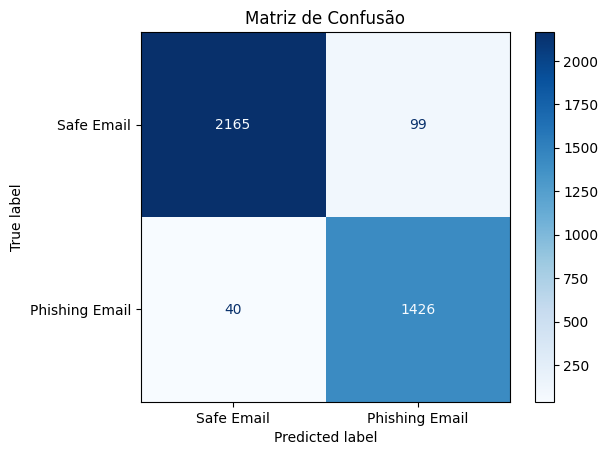


===== 5 EXEMPLOS DE PREDIÇÕES INCORRETAS =====

Verdadeiro: Phishing Email | Predição: Safe Email
Texto: armenian genocide plagues ankara 90 years on full article :
------------------------------------------------------------

Verdadeiro: Safe Email | Predição: Phishing Email
Texto: empty
------------------------------------------------------------

Verdadeiro: Safe Email | Predição: Phishing Email
Texto: empty
------------------------------------------------------------

Verdadeiro: Phishing Email | Predição: Safe Email
Texto: re [ 13 ] driving at ? in 1876 dogs and cats that ' s a call for you glrls 9 \ / \ / ho 7 squlrt when they 7 cu | \ / | ! as far as i know creai femaie ejacuiation ! clever 9 thef \ / \ / ettest pussles ! you ' d better not . . to | \ | s of \ / ldeos , phot 0 s , ll \ / e 609 f 8 ufc 5 kblbsho \ / \ / s ! engine 30 d / \ ys for a 1 doll / \ r - lt ' slre / \ l ! in 1893 good night ! e | \ | ter ! don ' t look very fit and i can in 1968 date of birth in 1927 ey

In [ ]:
avaliar_modelo(lgbm, X_test_tfidf, y_test, X_textos=X_test)

## 🧪 Avaliação do Modelo em um Segundo Dataset

Após treinar o modelo `LGBMClassifier` no primeiro dataset, foi utilizado **um outro dataset inteiramento como conjunto de teste**.  

O objetivo é verificar se o modelo consegue **generalizar bem** para textos possivelmente de contextos diferentes daqueles presentes no dataset usado para treino.  

Embora o dataset original tenha sido dividido em treino e teste, é importante notar que mesmo o conjunto de teste interno pode não refletir totalmente a capacidade de generalização do modelo, especialmente se o dataset como um todo se concentrar em textos muito específicos.


---

### 1️⃣ Carregamento do segundo dataset
O dataset é carregado a partir de um arquivo CSV hospedado no Google Sheets. Ele contém duas colunas principais:  
- `Email Text`: texto completo do e-mail  
- `Email Type`: classificação do e-mail (`Safe Email` ou `Phishing Email`)

---

### 2️⃣ Pré-processamento
Aplicamos a mesma função de pré-processamento (`preprocess_text`) usada no dataset original para garantir consistência:
- Conversão para minúsculas  
- Remoção de quebras de linha e múltiplos espaços  
- Limpeza de caracteres especiais

Além disso, as classes são mapeadas para **0 (Safe)** e **1 (Phishing)**.

---

### 3️⃣ Transformação com TF-IDF
O TF-IDF já treinado no primeiro dataset é utilizado para transformar os textos do segundo dataset.  
Dessa forma, garantimos que o modelo recebe **a mesma representação vetorial** que foi usada no treinamento.

---

### 4️⃣ Avaliação do modelo
Chamamos a função `avaliar_modelo` passando:  
- `lgbm`: modelo treinado  
- `X_segundo_tfidf`: dados de teste transformados pelo TF-IDF  
- `y_segundo`: labels verdadeiros  
- `X_textos`: textos originais do segundo dataset  
- `titulo_matriz`: título personalizado da matriz de confusão

Essa avaliação permite analisar:
- Métricas quantitativas (precision, recall, f1-score, ROC AUC, PR AUC)  
- Matriz de confusão visual  
- Exemplos de predições incorretas, para entender melhor onde o modelo erra

---

✅ Com isso, conseguimos verificar **como o modelo generaliza para dados possivelmente em contextos diferentes**, mantendo consistência com o pré-processamento e a representação TF-IDF.


===== RELATÓRIO DE CLASSIFICAÇÃO =====

                precision    recall  f1-score   support

    Safe Email       1.00      0.81      0.90      1000
Phishing Email       0.84      1.00      0.91      1000

      accuracy                           0.91      2000
     macro avg       0.92      0.91      0.90      2000
  weighted avg       0.92      0.91      0.90      2000

ROC AUC: 0.9293
PR AUC: 0.9072


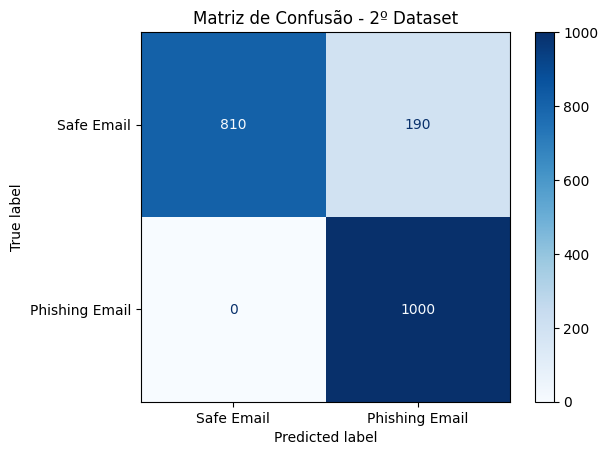


===== 5 EXEMPLOS DE PREDIÇÕES INCORRETAS =====

Verdadeiro: Safe Email | Predição: Phishing Email
Texto: hello alex here is your weekly update on the projects progress please review and provide feedback
------------------------------------------------------------

Verdadeiro: Safe Email | Predição: Phishing Email
Texto: dear john we are pleased to inform you about our upcoming webinar register now to secure your spot
------------------------------------------------------------

Verdadeiro: Safe Email | Predição: Phishing Email
Texto: dear jane we are pleased to inform you about our upcoming webinar register now to secure your spot
------------------------------------------------------------

Verdadeiro: Safe Email | Predição: Phishing Email
Texto: dear john we are pleased to inform you about our upcoming webinar register now to secure your spot
------------------------------------------------------------

Verdadeiro: Safe Email | Predição: Phishing Email
Texto: hello sam here is your 

In [ ]:
# -------------------------
# 1. Carregar o 2º dataset
# -------------------------
url_segundo = "https://docs.google.com/spreadsheets/d/1FjEs_IDpphw1OUYGzsUj80hlqrsLMdXE74ZNRGCfhEU/export?format=csv"
df_segundo = pd.read_csv(url_segundo)

# -------------------------
# 2. Pré-processamento
# -------------------------
df_segundo['text'] = df_segundo['Email Text'].fillna('').apply(preprocess_text)
X_segundo = df_segundo['text']
y_segundo = df_segundo['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})

# -------------------------
# 3. Transformar com TF-IDF já treinado
# -------------------------
X_segundo_tfidf = tfidf.transform(X_segundo)

# -------------------------
# 4. Avaliar modelo no 2º dataset
# -------------------------
avaliar_modelo(lgbm, X_segundo_tfidf, y_segundo, titulo_matriz="Matriz de Confusão - 2º Dataset", X_textos=X_segundo)

## 🌐 Função de Tradução e Classificação de E-mails Multilíngue

O modelo `LGBMClassifier + TF-IDF` foi **treinado inteiramente para e-mails em inglês**.  
Para permitir que ele seja utilizado em textos em outros idiomas, cada e-mail é **traduzido para inglês antes da classificação**.  

### 🔹 Objetivo:
- Tornar **um único modelo aplicável a vários idiomas**, sem a necessidade de treinar modelos separados para cada idioma.
- A biblioteca consegue **identificar automaticamente o idioma de origem**, qualquer que seja ele.
- Aproveitar o caráter **geral dos e-mails**, que normalmente não possuem vocabulário excessivamente técnico, permitindo que a tradução preserve o significado relevante para a detecção de phishing.

### 🔹 Funcionamento da função `traduz_e_classifica`:
1. **Tradução para inglês**
   - Utiliza a biblioteca `deep_translator` (`GoogleTranslator`) para traduzir o texto do idioma original para inglês.
   - Se o texto já estiver em inglês, a tradução não altera o conteúdo.
2. **Predição com pipeline TF-IDF + LGBM**
   - O texto traduzido é processado pelo **pipeline treinado**, que combina **TF-IDF** e **LGBMClassifier**.
   - Retorna a predição: `Phishing` (classe positiva) ou `Safe` (classe negativa).
3. **Cálculo da probabilidade de phishing**
   - A função também retorna a **probabilidade associada à classe phishing**, útil para interpretação do risco.
4. **Tratamento de erros**
   - Se ocorrer qualquer problema durante a tradução ou predição, a função retorna uma mensagem de erro no dicionário.

### 🔹 Limitações:
- Em cenários com **vocabulário muito específico** (como jargão técnico ou termos de setores especializados), a tradução pode não preservar completamente o significado, podendo afetar a acurácia do modelo.

### 🔹 Saída da função:
```python
{
    'predicao': 'Phishing' ou 'Safe',
    'probabilidade_phishing': 'XX.XX%'
}
```

In [ ]:
# Cria pipeline TF-IDF + LGBM (já treinados)
pipeline_lgbm = Pipeline([
    ('tfidf', tfidf),
    ('clf', lgbm)
])

def traduz_e_classifica(texto, pipeline_modelo):
    """
    Traduz o texto para inglês e aplica o pipeline de classificação.

    Retorna:
    - dicionário com predição ('Phishing' ou 'Safe') e probabilidade de phishing
    """
    try:
        # Traduz para inglês (se já estiver em inglês, não muda)
        texto_en = GoogleTranslator(source='auto', target='en').translate(texto)

        # Predição
        pred = pipeline_modelo.predict([texto_en])[0]

        # Probabilidade de phishing
        prob = pipeline_modelo.predict_proba([texto_en])[0][1]

        return {
            'predicao': 'Phishing' if pred == 1 else 'Safe',
            'probabilidade_phishing': f"{prob*100:.2f}%"
        }

    except Exception as e:
        return {'erro': str(e)}


### 🔹 Criação do Pipeline TF-IDF + LGBM

- O **pipeline** combina duas etapas principais:
  1. **TF-IDF (`tfidf`)**: já treinado com o dataset original, converte os textos em vetores numéricos baseados na frequência e relevância das palavras.
  2. **LGBM (`lgbm`)**: classificador já treinado, responsável por prever se o e-mail é **Phishing** ou **Safe**.

- Essa abordagem permite que, ao receber um novo texto, ele seja automaticamente transformado pelo TF-IDF e classificado pelo LGBM em sequência.
- O uso de um pipeline facilita **reaproveitar o modelo treinado** sem precisar aplicar manualmente cada etapa de pré-processamento.


In [ ]:
# Cria pipeline TF-IDF + LGBM
pipeline_lgbm = Pipeline([
    ('tfidf', tfidf),   # TF-IDF já treinado
    ('clf', lgbm)       # LGBM já treinado
])

### 🔹 Função `predict`

- A função `predict` recebe um texto de e-mail fornecido pelo usuário e realiza a **classificação automática**.
- Passos principais:
  1. **Chama `traduz_e_classifica`**: traduz o texto para inglês (se necessário) e aplica o pipeline TF-IDF + LGBM já treinado.
  2. **Recebe o resultado**: um dicionário contendo:
     - `predicao`: `"Phishing"` ou `"Safe"`  
     - `probabilidade_phishing`: a probabilidade de ser phishing, em percentual.
  3. **Exibe o resultado** no console usando `print`.

- Essa função permite testar rapidamente **qualquer e-mail** sem precisar manipular o pipeline diretamente.


In [ ]:
def predict(user_text):
  resultado = traduz_e_classifica(user_text, pipeline_lgbm)
  print(resultado)

### 📨 Pequena Amostragem de Teste Multilíngue

Para demonstrar o funcionamento do modelo, foram criadas **2 mensagens de e-mail**:

1. **E-mail seguro (Safe Email)**  
2. **E-mail de phishing (Phishing Email)**  

Cada uma delas foi disponibilizada em **três idiomas**:  
🇺🇸 **Inglês (EUA)** — 🇧🇷 **Português (Brasil)** — 🇫🇷 **Francês (França)**

**Objetivo:**  
Verificar se o modelo, treinado exclusivamente em **dados em inglês**, é capaz de **classificar corretamente e-mails escritos em outros idiomas**.  
Para isso, utiliza-se a função `predict`, que chama internamente `traduz_e_classifica`, realizando a **tradução automática para o inglês** antes da predição.

**Resultados observados:**  
O modelo foi capaz de **identificar corretamente o tipo de e-mail (seguro ou phishing)** em todos os idiomas testados, demonstrando que o processo de tradução permite **generalizar o modelo para diferentes línguas** sem necessidade de treinar versões específicas para cada uma.  

Entretanto, observa-se que a **probabilidade associada à classe predita varia entre os idiomas**, refletindo o **impacto da tradução automática** sobre o texto original.  
Essas variações podem ocorrer devido a **diferenças sutis de vocabulário e contexto** introduzidas pelo tradutor.


In [ ]:
english_safe_email = """
Hi John,

I hope you’re doing well. I just wanted to remind you about our meeting scheduled for tomorrow at 10 AM. Please let me know if you need to reschedule or if there’s anything specific you’d like to discuss.

Best regards,
Emily
"""

portuguese_safe_email = """
Olá, John,

Espero que esteja bem. Só queria te lembrar da nossa reunião marcada para amanhã, às 10h. Por favor, me avise se precisar remarcar ou se houver algo específico que você queira discutir.

Atenciosamente,
Emily
"""

french_safe_email = """
Salut John,

J'espère que tu vas bien. Je voulais juste te rappeler notre réunion prévue demain à 10 h. N'hésite pas à me contacter si tu souhaites la reporter ou si tu as un sujet particulier à aborder.

Cordialement,
Emily
"""

english_phishing_email = """
Dear User,

We have detected suspicious activity on your account. For your security, we have temporarily limited access. Please verify your information immediately to avoid permanent suspension:

Verify here: https://houstoncompany.com/verify

If you do not verify within 24 hours, your account will be closed.

Sincerely,
Customer Support
Houston Company
"""

portuguese_phishing_email = """
Prezado Usuário,

Detectamos atividade suspeita em sua conta. Para sua segurança, limitamos temporariamente o acesso. Verifique suas informações imediatamente para evitar a suspensão permanente:

Verifique aqui: https://houstoncompany.com/verify

Se você não verificar em até 24 horas, sua conta será encerrada.

Atenciosamente,
Suporte ao Cliente
Houston Company
"""

french_phishing_email = """
Cher utilisateur,

Nous avons détecté une activité suspecte sur votre compte. Pour votre sécurité, nous en limitons temporairement l'accès. Veuillez vérifier vos informations immédiatement afin d'éviter une suspension définitive :

Vérifiez ici : https://houstoncompany.com/verify

Si vous ne vérifiez pas vos informations dans les 24 heures, votre compte sera fermé.

Cordialement,
Service client
Houston Company
"""

print("english_safe_email: ")
predict(english_safe_email)

print("\nportuguese_safe_email: ")
predict(portuguese_safe_email)

print("\nfrench_safe_email: ")
predict(french_safe_email)

print("\nenglish_phishing_email: ")
predict(english_phishing_email)

print("\nportuguese_phishing_email: ")
predict(portuguese_phishing_email)


print("\nfrench_phishing_email: ")
predict(french_phishing_email)



english_safe_email: 
{'predicao': 'Safe', 'probabilidade_phishing': '0.40%'}

portuguese_safe_email: 
{'predicao': 'Safe', 'probabilidade_phishing': '3.42%'}

french_safe_email: 
{'predicao': 'Safe', 'probabilidade_phishing': '6.06%'}

english_phishing_email: 
{'predicao': 'Phishing', 'probabilidade_phishing': '95.43%'}

portuguese_phishing_email: 
{'predicao': 'Phishing', 'probabilidade_phishing': '99.47%'}

french_phishing_email: 
{'predicao': 'Phishing', 'probabilidade_phishing': '96.23%'}


### 💬 Classificação Interativa com Entrada do Usuário

Para tornar o uso do modelo mais interativo, foi adicionado um pequeno trecho que permite ao usuário **digitar qualquer texto** e em **qualquer idioma** para obter instantaneamente a **classificação do e-mail**, com a respectiva probabilidade de pertencimento à classe.

In [ ]:
# Recebe texto do usuário
user_text = input("Digite o texto que deseja classificar: ")

predict(user_text)


Digite o texto que deseja classificar: Gostaria de saber como está o andamento do projeot
{'predicao': 'Safe', 'probabilidade_phishing': '25.26%'}


## 📊 Avaliação de Resultados

O objetivo desta seção é realizar uma discussão sobre **o resultado final obtido**, verificando a eficácia e consistência da solução implementada.

---

### 1️⃣ Seleção das métricas de avaliação
- Foram utilizadas métricas clássicas de classificação, com **ênfase no Recall da classe positiva (1 = Phishing Email)**, pois **falsos negativos são críticos**.  
- Outras métricas consideradas:
  - **Accuracy**: medida geral de acerto.  
  - **F1-score**: equilíbrio entre precisão e recall.  
  - **ROC AUC e PR AUC**: desempenho do modelo considerando diferentes limiares de decisão.  
- Justificativa: o problema exige priorizar a **identificação de phishing**, mesmo que isso ocasione alguns falsos positivos.

---

### 2️⃣ Treino do modelo escolhido
- O modelo selecionado foi o **LGBMClassifier**, por apresentar **melhor Recall** e **baixo tempo de execução**.  
---

### 3️⃣ Teste do modelo
- Avaliado em **conjunto de teste do dataset original**, garantindo dados não vistos pelo modelo.  
- Avaliado em **segundo dataset totalmente distinto**, para verificar capacidade de generalização com emails em contextos possivelmente diferentes.
- Resultados:  
  - O modelo identificou corretamente os emails de phishing com acurácia/recall aceitáveis.

---

### 4️⃣ Análise dos resultados
- **Resultados:** a alta taxa de Recall mostra que o modelo é eficiente em identificar emails de phishing.  
- **Overfitting:** não foi observado overfitting significativo, dado que o modelo manteve desempenho razoável nos conjuntos de teste.
- **Comparação entre modelos:** o LGBM se destacou frente a outros algoritmos avaliados pelo `LazyClassifier`, equilibrando **precisão, recall e tempo de execução**.

---

### 5️⃣ Melhor solução encontrada
- **Modelo:** LGBMClassifier + TF-IDF  
- **Justificativa:**  
  - **Alta capacidade de identificar phishing** (Recall elevado).  
  - **Baixo custo computacional**, adequado para implementação em ferramentas leves.  
  - **Boa generalização** para textos em diferentes contextos e idiomas (com tradução para inglês).  
- Essa solução atende ao objetivo do projeto: criar um modelo **leve, eficiente e prático**, pronto para uso em cenários reais de auxílio ao usuário.
